In [1]:
import polars as pl
from datasets import load_dataset
from utils import preprocessing

ds = load_dataset("fancyzhx/ag_news")

/Users/hugo/PycharmProjects/Chatbot_M1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/hugo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/hugo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/hugo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hugo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/hugo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [3]:
# Convertir chaque split en Polars DataFrame
train_pl = pl.DataFrame(ds["train"][:])

# Affichage
print(train_pl.head())

shape: (5, 2)
┌─────────────────────────────────┬───────┐
│ text                            ┆ label │
│ ---                             ┆ ---   │
│ str                             ┆ i64   │
╞═════════════════════════════════╪═══════╡
│ Wall St. Bears Claw Back Into … ┆ 2     │
│ Carlyle Looks Toward Commercia… ┆ 2     │
│ Oil and Economy Cloud Stocks' … ┆ 2     │
│ Iraq Halts Oil Exports from Ma… ┆ 2     │
│ Oil prices soar to all-time re… ┆ 2     │
└─────────────────────────────────┴───────┘


In [4]:
label_names = ds["train"].features["label"].names
print(label_names)

train_pl = train_pl.with_columns([
    pl.col("label").map_elements(lambda x: label_names[x], return_dtype=pl.String).alias("label_name")
])

train_pl.head()

['World', 'Sports', 'Business', 'Sci/Tech']


text,label,label_name
str,i64,str
"""Wall St. Bears Claw Back Into …",2,"""Business"""
"""Carlyle Looks Toward Commercia…",2,"""Business"""
"""Oil and Economy Cloud Stocks' …",2,"""Business"""
"""Iraq Halts Oil Exports from Ma…",2,"""Business"""
"""Oil prices soar to all-time re…",2,"""Business"""


In [5]:
df = train_pl.with_columns([
    pl.col("text").map_elements(preprocessing, return_dtype=pl.String).alias("text_cleaned")
])

df.head()

text,label,label_name,text_cleaned
str,i64,str,str
"""Wall St. Bears Claw Back Into …",2,"""Business""","""wall bear claw back black reut…"
"""Carlyle Looks Toward Commercia…",2,"""Business""","""carlyle look toward commercial…"
"""Oil and Economy Cloud Stocks' …",2,"""Business""","""oil economy cloud stock outloo…"
"""Iraq Halts Oil Exports from Ma…",2,"""Business""","""iraq halt oil export main sout…"
"""Oil prices soar to all-time re…",2,"""Business""","""oil price soar record pose new…"


# Entrainement du Model ML

In [6]:
from sklearn.model_selection import train_test_split
# Séparer X et Y train_test_split
X = df["text_cleaned"].to_list()
y = df["label"].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [7]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.metrics import f1_score, accuracy_score

def objective(trial):
    # Choix du modèle
    model_name = trial.suggest_categorical("model", ["LogisticRegression", "SGD", "Ridge"])

    # Paramètres communs
    max_features = trial.suggest_int("max_features", 1000, 10000, step=1000)
    vectorizer = TfidfVectorizer(max_features=max_features)

    # Sélection du modèle avec hyperparamètres
    if model_name == "LogisticRegression":
        clf = LogisticRegression(
            max_iter=1000,
            C=trial.suggest_float("C", 1e-3, 10, log=True)
        )
    elif model_name == "SGD":
        clf = SGDClassifier(
            loss="log_loss",
            penalty=trial.suggest_categorical("penalty", ["l2", "l1"]),
            alpha=trial.suggest_float("alpha", 1e-5, 1e-2, log=True),
            max_iter=1000,
            random_state=42
        )
    elif model_name == "Ridge":
        clf = RidgeClassifier(
            alpha=trial.suggest_float("alpha", 0.1, 10, log=True)
        )

    # Pipeline
    pipeline = Pipeline([
        ("vectorizer", vectorizer),
        ("classifier", clf)
    ])

    # Entraînement + évaluation
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    f1 = f1_score(y_test, preds, average='macro')
    acc = accuracy_score(y_test, preds)

    return f1, acc

# Étude multi-objectifs
study = optuna.create_study(
    directions=["maximize", "maximize"]
)
study.optimize(objective, n_trials=300)

# Résumé des meilleurs essais
print("Best trials:")
for t in study.best_trials:
    print(f"F1 macro: {t.values[0]:.4f}, Accuracy: {t.values[1]:.4f}, Params: {t.params}")

[I 2025-06-22 18:39:33,067] A new study created in memory with name: no-name-f8aea316-8185-4ec8-8e18-cbb2368fcd44
[I 2025-06-22 18:39:34,600] Trial 0 finished with values: [0.8578891402005521, 0.8589166666666667] and parameters: {'model': 'SGD', 'max_features': 2000, 'penalty': 'l2', 'alpha': 0.0020503327629349064}.
[I 2025-06-22 18:39:38,175] Trial 1 finished with values: [0.8854543002498503, 0.885875] and parameters: {'model': 'LogisticRegression', 'max_features': 3000, 'C': 0.02562226900493634}.
[I 2025-06-22 18:39:39,906] Trial 2 finished with values: [0.9041617406110991, 0.9044166666666666] and parameters: {'model': 'Ridge', 'max_features': 4000, 'alpha': 1.7083852803336428}.
[I 2025-06-22 18:39:41,782] Trial 3 finished with values: [0.913510202973439, 0.9137083333333333] and parameters: {'model': 'Ridge', 'max_features': 9000, 'alpha': 0.4859009380455021}.
[I 2025-06-22 18:39:43,314] Trial 4 finished with values: [0.8978640336139234, 0.89825] and parameters: {'model': 'SGD', 'max

Best trials:
F1 macro: 0.9148, Accuracy: 0.9150, Params: {'model': 'LogisticRegression', 'max_features': 9000, 'C': 1.9550671399076747}


In [8]:
import optuna.visualization as vis

# Affiche la frontière de Pareto
vis.plot_pareto_front(study, target_names=["F1 macro", "Accuracy"]).show()
vis.plot_optimization_history(
    study,
    target=lambda t: t.values[0],   # F1 macro
    target_name="F1 Macro"
)
vis.plot_param_importances(
    study,
    target=lambda t: t.values[1],   # Accuracy
    target_name="Accuracy"
)

In [9]:
vis.plot_parallel_coordinate(study, target=lambda t: t.values[0])
vis.plot_slice(study, target=lambda t: t.values[1])

/Users/hugo/PycharmProjects/Chatbot_M1/.venv/lib/python3.11/site-packages/optuna/visualization/_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.

[W 2025-06-22 18:55:10,724] Your study has only completed trials with missing parameters.


In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.pipeline import Pipeline

# Sélection du meilleur essai selon F1 macro (index 0)
best_trial = max(study.best_trials, key=lambda t: t.values[0])
best_params = best_trial.params

# Vectorizer
vectorizer = TfidfVectorizer(max_features=best_params["max_features"])

# Sélection du modèle en fonction des paramètres
model_name = best_params["model"]

if model_name == "LogisticRegression":
    clf = LogisticRegression(
        max_iter=1000,
        C=best_params["C"]
    )

elif model_name == "SGD":
    clf = SGDClassifier(
        loss="log_loss",
        penalty=best_params["penalty"],
        alpha=best_params["alpha"],
        max_iter=1000,
        random_state=42
    )

elif model_name == "Ridge":
    clf = RidgeClassifier(
        alpha=best_params["alpha"]
    )

else:
    raise ValueError(f"Modèle non reconnu : {model_name}")

# Création du pipeline
pipeline = Pipeline([
    ("vectorizer", vectorizer),
    ("classifier", clf)
])

# Entraînement final
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

# Résultats
print(f"\n📌 Meilleur modèle : {model_name}")
print("\nClassification Report :")
print(classification_report(y_test, preds))


📌 Meilleur modèle : LogisticRegression

Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      6000
           1       0.95      0.98      0.97      6000
           2       0.89      0.89      0.89      6000
           3       0.89      0.89      0.89      6000

    accuracy                           0.91     24000
   macro avg       0.91      0.91      0.91     24000
weighted avg       0.91      0.91      0.91     24000



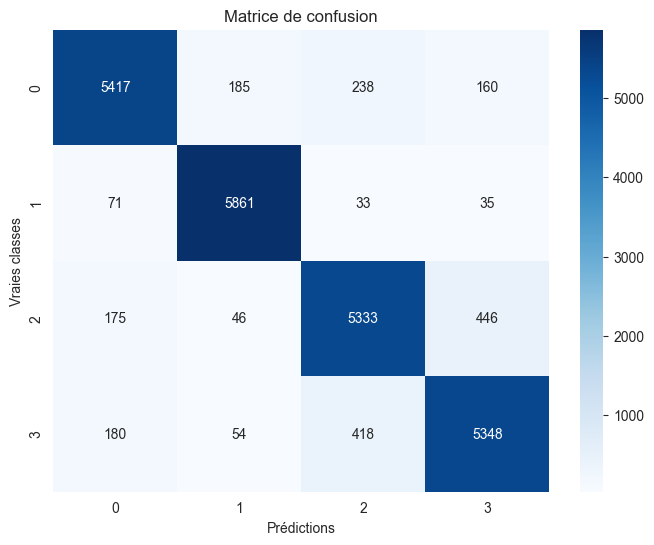

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Génération de la matrice
cm = confusion_matrix(y_test, preds)
labels = [0, 1, 2, 3]

# Tracé avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.show()

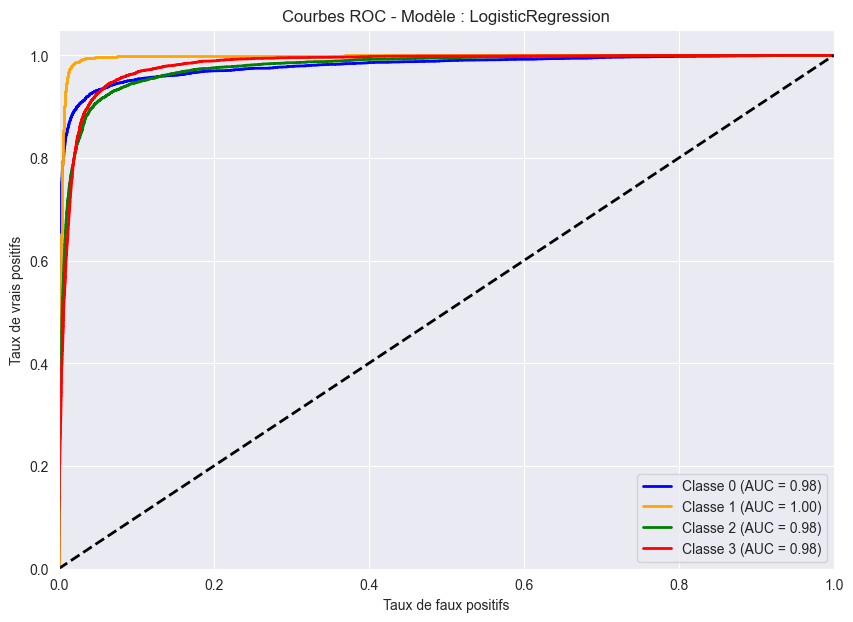

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Binarisation des labels
classes = sorted(list(set(y_test)))
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Si le modèle ne supporte pas predict_proba (ex: RidgeClassifier), on essaie decision_function
if hasattr(pipeline.named_steps["classifier"], "predict_proba"):
    y_score = pipeline.predict_proba(X_test)
elif hasattr(pipeline.named_steps["classifier"], "decision_function"):
    y_score = pipeline.decision_function(X_test)
else:
    raise RuntimeError("Ce modèle ne fournit ni predict_proba ni decision_function.")

# Courbe ROC par classe
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer les courbes ROC
plt.figure(figsize=(10, 7))
colors = ["blue", "orange", "green", "red"]
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"Classe {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"Courbes ROC - Modèle : {model_name}")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Test du Pipeline

In [13]:
# Exemple de 4 phrases à tester
texts = [
    "Despite numerous concerns — including the Israel-Iran war, trade tensions, a growing federal deficit, immigration raids, low business confidence, and expected profit declines — the stock market remains resilient. The S&P 500 is close to its record high, thanks to eased trade policies, stable inflation, and a still-strong economy. However, beneath the surface, warning signs persist. Derivatives markets suggest investors expect a future downturn, and concerns over the $35 trillion U.S. debt remain. Analysts warn that the market's calm appearance masks significant underlying uncertainty.",
    "The 25-year-old Swedish pole vaulter broke his own world record for the twelfth time since 2020 on Sunday. He set the new mark at 6.28 meters during a meet in Stockholm, Sweden, in front of his home crowd.",
    "In twenty months, more than 55,000 Palestinians have been killed in the Gaza Strip, and nearly 950 in the occupied West Bank. But Israel’s destructive campaign began well before October 7, 2023. For over seventy-five years, Israel has done everything to make a Palestinian state impossible, according to Monique Chemillier-Gendreau, a professor of public law and political science, expert in international law and state theory, legal adviser before international courts, and author of Making a Palestinian State Impossible: Israel’s Goal Since Its Creation.",
    "Gemini Automatically Summarizes Your PDFs and Tells You What to Do Next. Gemini has been able to interact with PDF files for some time now. But a new feature significantly boosts its usefulness."
]

label_names = ds["train"].features["label"].names

# Prétraitement des phrases
processed_texts = [preprocessing(text) for text in texts]

# Prédictions
predicted_classes = pipeline.predict(processed_texts)

# Affichage
for i, (raw, cleaned, pred) in enumerate(zip(texts, processed_texts, predicted_classes)):
    label_str = label_names[pred]
    print(f"Phrase {i+1} : \"{raw}\"")
    print(f" → Prétraité : \"{cleaned}\"")
    print(f" → Classe prédite : {pred} ({label_str})\n")

Phrase 1 : "Despite numerous concerns — including the Israel-Iran war, trade tensions, a growing federal deficit, immigration raids, low business confidence, and expected profit declines — the stock market remains resilient. The S&P 500 is close to its record high, thanks to eased trade policies, stable inflation, and a still-strong economy. However, beneath the surface, warning signs persist. Derivatives markets suggest investors expect a future downturn, and concerns over the $35 trillion U.S. debt remain. Analysts warn that the market's calm appearance masks significant underlying uncertainty."
 → Prétraité : "despite numerous concern include war trade tension grow federal deficit immigration raid low business confidence expect profit decline stock market remain resilient p close record high thanks ease trade policy stable inflation economy however beneath surface warn sign persist derivative market suggest investor expect future downturn concern trillion debt remain analyst warn ma

In [17]:
import joblib
name = best_trial.params.get("model")
# Sauvegarde dans un fichier
joblib.dump(pipeline, f"ML_Models/model_pipeline_ML_{name}.joblib")

['ML_Models/model_pipeline_ML_LogisticRegression.joblib']

In [16]:
best_trial.params

{'model': 'LogisticRegression', 'max_features': 9000, 'C': 1.9550671399076747}